In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Whirling Triangle: Golden Ratio–Based Triangular Feature Extraction for Medical X-ray Classification

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import os

phi = 1.618  # golden ratio

# --- Divide a line segment in golden ratio ---
def divide_point(p1, p2, ratio=phi):
    x = int((p1[0] + ratio * p2[0]) / (1 + ratio))
    y = int((p1[1] + ratio * p2[1]) / (1 + ratio))
    return (x, y)

# --- Preprocess: make square padded image ---
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    h, w, _ = img.shape
    side = max(h, w)
    square_img = np.full((side, side, 3), (0, 0, 0), dtype=np.uint8)
    x_offset = (side - w) // 2
    y_offset = (side - h) // 2
    square_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
    return square_img

# --- Extract stats from triangle region ---
def extract_triangle_features(img, pts):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(pts)], 255)
    block = cv2.bitwise_and(img, img, mask=mask)
    gray = cv2.cvtColor(block, cv2.COLOR_BGR2GRAY)
    pixels = gray[gray > 0]
    if len(pixels) == 0:
        return [0, 0, 0, 0, 0]
    return [np.mean(pixels), np.median(pixels), np.std(pixels), skew(pixels), kurtosis(pixels)]

# --- Golden subdivision: return 4 sub-triangles (not draw) ---
def golden_subdivide(A, B, C):
    D = divide_point(A, C, phi)
    E = divide_point(B, D, phi)
    F = divide_point(C, E, phi)
    return {
        "ABD": [A, B, D],
        "BCE": [B, C, E],
        "DFC": [D, F, C],
        "DEF": [D, E, F]
    }

# --- Build initial 6 triangles from hexagon around circle ---
def split_into_triangles(img):
    h, w, _ = img.shape
    cx, cy = w // 2, h // 2
    radius = int(np.sqrt((w/2)**2 + (h/2)**2))
    hexagon = []
    for i in range(6):
        angle = np.deg2rad(60 * i - 30)
        x = int(cx + radius * np.cos(angle))
        y = int(cy + radius * np.sin(angle))
        hexagon.append((x, y))
    triangles = []
    for i in range(6):
        pt1, pt2, pt3 = (cx, cy), hexagon[i], hexagon[(i+1) % 6]
        triangles.append([pt1, pt2, pt3])
    return triangles, (cx, cy), radius, hexagon
# --- Process single image into feature dict ---
def process_image(img_path, label):
    img = preprocess_image(img_path)
    if img is None:
        return None
    triangles, _, _, _ = split_into_triangles(img)
    # feats_img = {"image_name": os.path.basename(img_path)}
    feats_img = {}
    for i, tri in enumerate(triangles):
        subtris = golden_subdivide(tri[1], tri[2], tri[0])
        for j, (name, subtri) in enumerate(subtris.items(), start=1):
            feats = extract_triangle_features(img, subtri)
            feats_img[f"T{i+1}_{name}_mean"] = feats[0]
            feats_img[f"T{i+1}_{name}_median"] = feats[1]
            feats_img[f"T{i+1}_{name}_std"] = feats[2]
            feats_img[f"T{i+1}_{name}_skew"] = feats[3]
            feats_img[f"T{i+1}_{name}_kurt"] = feats[4]
    feats_img["label"] = label
    return feats_img


# --- Process dataset into CSV ---
def process_dataset(dataset_path, save_csv=True):
    label_map = {"Normal":0, "Osteoporosis":1, "Osteopenia":2}
    all_features = []
    for label in label_map.keys():
        folder = os.path.join(dataset_path, label)
        if not os.path.exists(folder):
            continue
        for file in os.listdir(folder):
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".jpeg")):
                img_path = os.path.join(folder, file)
                feats = process_image(img_path, label_map[label])
                if feats is not None:
                    all_features.append(feats)
    df = pd.DataFrame(all_features)
    if save_csv:
        df.to_csv("dataset_features_golden.csv", index=False)
    return df

# --- Visualization ---
def visualize_shapes(img_path):
    img = preprocess_image(img_path)
    h, w, _ = img.shape
    radius = int(np.sqrt((w/2)**2 + (h/2)**2))
    canvas_size = 2 * radius + 50
    canvas = np.full((canvas_size, canvas_size, 3), (50, 50, 50), dtype=np.uint8)
    x_offset = (canvas_size - w) // 2
    y_offset = (canvas_size - h) // 2
    canvas[y_offset:y_offset+h, x_offset:x_offset+w] = img
    cx, cy = canvas_size // 2, canvas_size // 2

    # outer circle
    cv2.circle(canvas, (cx, cy), radius, (0, 255, 0), 3)

    # hexagon
    hexagon = []
    for i in range(6):
        angle = np.deg2rad(60 * i - 30)
        x = int(cx + radius * np.cos(angle))
        y = int(cy + radius * np.sin(angle))
        hexagon.append((x, y))
    cv2.polylines(canvas, [np.array(hexagon, np.int32)], isClosed=True, color=(0, 0, 255), thickness=3)

    # triangles + golden subdivision
    colors = [(255,255,0),(0,255,255),(255,0,255),(0,128,255)]
    for i in range(6):
        pt1, pt2, pt3 = (cx, cy), hexagon[i], hexagon[(i+1) % 6]
        cv2.polylines(canvas, [np.array([pt1, pt2, pt3], np.int32)], True, (255, 255, 255), 3)
        subtris = golden_subdivide(pt2, pt3, pt1)
        for j, subtri in enumerate(subtris.values()):
            cv2.polylines(canvas, [np.array(subtri, np.int32)], True, colors[j % len(colors)], 3)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

dataset_path = "/content/drive/MyDrive/Original_inputs"


In [ ]:
df = process_dataset(dataset_path, save_csv=True)
print("CSV saved: dataset_features_golden_new.csv")


In [ ]:
df

,T1_ABD_mean,T1_ABD_median,T1_ABD_std,T1_ABD_skew,T1_ABD_kurt,T1_BCE_mean,T1_BCE_median,T1_BCE_std,T1_BCE_skew,T1_BCE_kurt,...,T6_DFC_median,T6_DFC_std,T6_DFC_skew,T6_DFC_kurt,T6_DEF_mean,T6_DEF_median,T6_DEF_std,T6_DEF_skew,T6_DEF_kurt,label
0,0.000000,0.0,0.000000,0.000000,0.000000,11.214526,4.0,18.719315,2.852075,8.556883,...,120.0,50.407571,-0.189970,-1.445821,60.076551,44.0,52.975748,0.820616,-0.580600,0
1,0.000000,0.0,0.000000,0.000000,0.000000,37.812453,26.0,40.934386,1.434333,2.331765,...,151.0,41.070063,-0.901124,-0.288265,72.152574,44.0,61.113262,0.733616,-0.947366,0
2,0.000000,0.0,0.000000,0.000000,0.000000,30.549685,7.0,30.824349,0.704355,-1.057423,...,85.0,40.247988,0.360251,-0.432154,41.306924,34.0,41.960306,1.289648,1.028939,0
3,0.000000,0.0,0.000000,0.000000,0.000000,15.795861,5.0,26.041942,2.526949,6.472229,...,82.0,57.945711,0.209340,-1.131727,42.460936,7.0,56.494953,1.363134,0.448085,0
4,81.281768,17.0,110.366457,0.931396,-1.119567,75.731745,62.0,44.935629,1.148313,1.545535,...,153.0,21.853039,-0.295626,0.620010,113.240330,102.0,34.488359,0.111321,-0.468345,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,6.000000,6.0,0.000000,NaN,NaN,21.877016,6.0,45.997638,2.892751,6.883584,...,173.0,24.613278,-0.738015,0.463681,133.581427,137.0,51.185337,-0.327718,-0.443636,2
606,89.311958,99.0,61.615141,-0.053238,-1.153011,89.034932,86.0,55.572913,0.177968,-0.631057,...,7.0,17.184407,1.718266,1.510102,92.685400,74.0,56.747889,0.127463,-1.415032,2
607,7.655449,4.0,16.436762,6.639980,51.490960,53.639451,5.0,62.290284,0.829651,-0.803903,...,31.0,38.548545,1.335848,0.922367,129.282961,135.0,51.824741,-0.467362,-0.857465,2
608,7.003088,7.0,0.055480,17.913255,318.884720,12.161505,7.0,27.197439,5.444915,29.323488,...,135.0,60.368223,-0.557522,-0.587370,59.371876,14.0,63.111339,0.702547,-0.864839,2


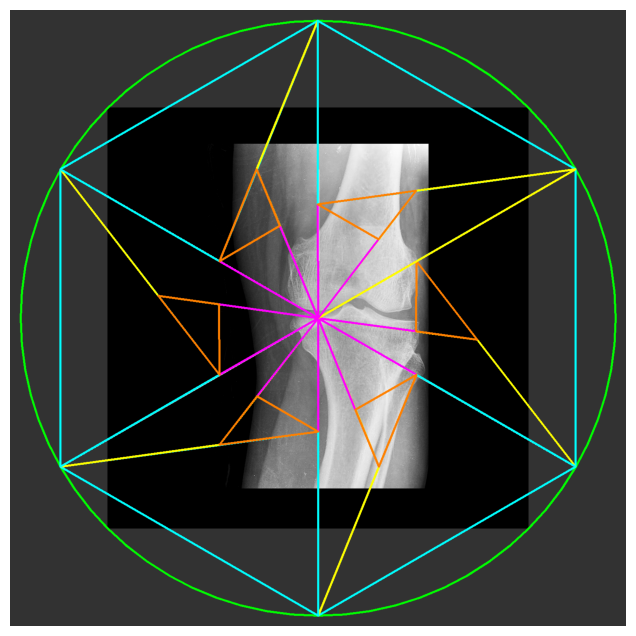

In [ ]:
# 2. Visualize shapes on one sample
demo_img = os.path.join(dataset_path, "Normal", "/content/drive/MyDrive/Original_inputs/Osteoporosis/105.png")
visualize_shapes(demo_img)

# Machine Learning Models


## 1. SVM Implementation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/dataset_features_golden.csv")
print("✅ Dataset Loaded, Shape:", df.shape)
df.head()


✅ Dataset Loaded, Shape: (610, 121)


,T1_ABD_mean,T1_ABD_median,T1_ABD_std,T1_ABD_skew,T1_ABD_kurt,T1_BCE_mean,T1_BCE_median,T1_BCE_std,T1_BCE_skew,T1_BCE_kurt,...,T6_DFC_median,T6_DFC_std,T6_DFC_skew,T6_DFC_kurt,T6_DEF_mean,T6_DEF_median,T6_DEF_std,T6_DEF_skew,T6_DEF_kurt,label
0,0.000000,0.0,0.000000,0.000000,0.000000,11.214526,4.0,18.719315,2.852075,8.556883,...,120.0,50.407571,-0.189970,-1.445821,60.076551,44.0,52.975748,0.820616,-0.580600,0
1,0.000000,0.0,0.000000,0.000000,0.000000,37.812453,26.0,40.934386,1.434333,2.331765,...,151.0,41.070063,-0.901124,-0.288265,72.152574,44.0,61.113262,0.733616,-0.947366,0
2,0.000000,0.0,0.000000,0.000000,0.000000,30.549685,7.0,30.824349,0.704355,-1.057423,...,85.0,40.247988,0.360251,-0.432154,41.306924,34.0,41.960306,1.289648,1.028939,0
3,0.000000,0.0,0.000000,0.000000,0.000000,15.795861,5.0,26.041942,2.526949,6.472229,...,82.0,57.945711,0.209340,-1.131727,42.460936,7.0,56.494953,1.363134,0.448085,0
4,81.281768,17.0,110.366457,0.931396,-1.119567,75.731745,62.0,44.935629,1.148313,1.545535,...,153.0,21.853039,-0.295626,0.620010,113.240330,102.0,34.488359,0.111321,-0.468345,0


### Data Preprocessing + Cleaning + Handling Missing Values + 80/20 Split

### Split into Features (X) and Labels (y)


In [ ]:
X = df.drop(columns=["label"],axis=1).values   # all features
y = df["label"].values                  # target labels


In [ ]:
print("Any Nan",np.isnan(X).any())
print("Any Nan",np.isnan(X).sum())

Any Nan True
Any Nan 1244


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

In [ ]:
print("Any Nan",np.isnan(X).any())
print("Any Nan",np.isnan(X).sum())

Any Nan False
Any Nan 0


In [ ]:

# Train-Test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, "Test set:", X_test.shape)

Training set: (488, 120) Test set: (122, 120)


### Feature Scaling (Very Important for SVM)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train SVM Classifier

In [ ]:
svm_clf = SVC(kernel="rbf", C=1, gamma="scale", random_state=42)  # RBF kernel
svm_clf.fit(X_train, y_train)

# Predictions
y_pred = svm_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("✅ SVM Accuracy:", round(acc * 100, 2), "%")


✅ SVM Accuracy: 66.39 %


### Classification Report

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Osteoporosis", "Osteopenia"]))



Classification Report:

              precision    recall  f1-score   support

      Normal       0.76      0.70      0.73        44
Osteoporosis       0.58      0.68      0.63        47
  Osteopenia       0.69      0.58      0.63        31

    accuracy                           0.66       122
   macro avg       0.68      0.66      0.66       122
weighted avg       0.67      0.66      0.67       122



### Confusion Matrix Heatmap

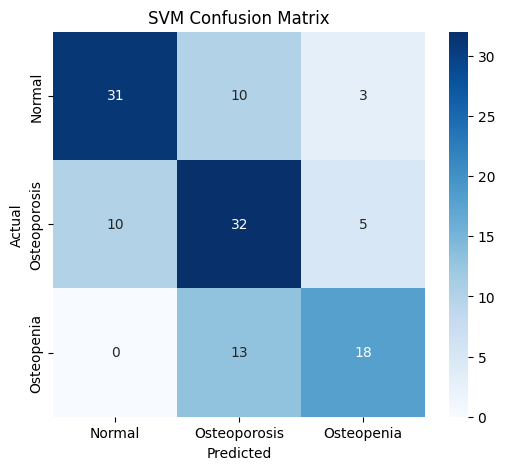

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Osteoporosis", "Osteopenia"],
            yticklabels=["Normal", "Osteoporosis", "Osteopenia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()


## 2. K Neighbor Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Train-Test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, "Test set:", X_test.shape)

Training set: (488, 120) Test set: (122, 120)


In [ ]:
print("Any Nan",np.isnan(X).any())
print("Any Nan",np.isnan(X).sum())

Any Nan False
Any Nan 0


In [ ]:
# ============================================================
# ⚖️ Feature Scaling (Important for KNN)
# ============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# ============================================================
# 🤖 Train KNN Classifier
# ============================================================
knn_clf = KNeighborsClassifier(n_neighbors=5)  # k=5
knn_clf.fit(X_train, y_train)

# Predictions
y_pred = knn_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("✅ KNN Accuracy:", round(acc * 100, 2), "%")


✅ KNN Accuracy: 65.57 %


In [ ]:
# ============================================================
# 📊 Classification Report
# ============================================================
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Osteoporosis", "Osteopenia"]))



Classification Report:

              precision    recall  f1-score   support

      Normal       0.68      0.77      0.72        44
Osteoporosis       0.62      0.64      0.63        47
  Osteopenia       0.67      0.52      0.58        31

    accuracy                           0.66       122
   macro avg       0.66      0.64      0.65       122
weighted avg       0.66      0.66      0.65       122



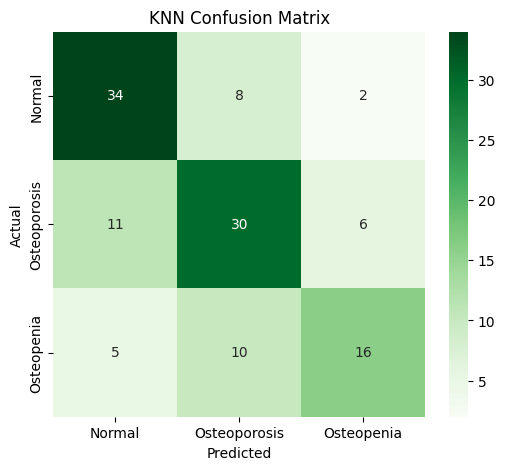

In [ ]:
# ============================================================
# 🔥 Confusion Matrix Heatmap
# ============================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Normal", "Osteoporosis", "Osteopenia"],
            yticklabels=["Normal", "Osteoporosis", "Osteopenia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()


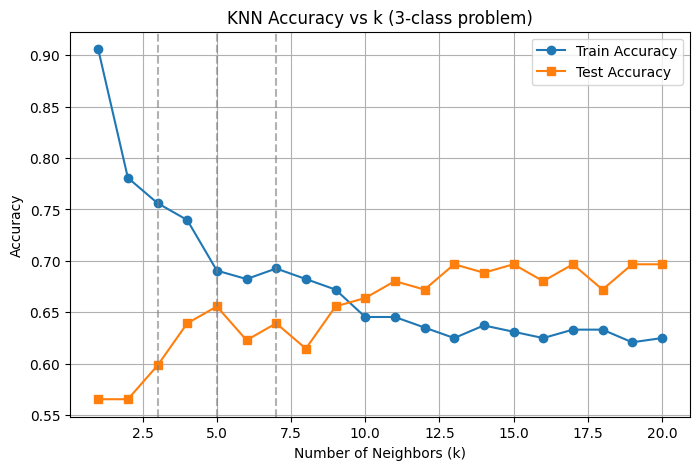

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_acc = []
test_acc = []
k_values = range(1, 21)  # test k=1 to 20

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc.append(accuracy_score(y_train, knn.predict(X_train)))
    test_acc.append(accuracy_score(y_test, knn.predict(X_test)))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(k_values, train_acc, marker='o', label="Train Accuracy")
plt.plot(k_values, test_acc, marker='s', label="Test Accuracy")
plt.axvline(x=3, color="gray", linestyle="--", alpha=0.6)  # mark k=3
plt.axvline(x=5, color="gray", linestyle="--", alpha=0.6)  # mark k=5
plt.axvline(x=7, color="gray", linestyle="--", alpha=0.6)  # mark k=7
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k (3-class problem)")
plt.legend()
plt.grid(True)
plt.show()

## 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [ ]:
# ============================================================
# 🤖 Train Random Forest Classifier
# ============================================================
rf_clf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # expand until all leaves are pure
    random_state=42,
    n_jobs=-1               # use all CPU cores
)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("✅ Random Forest Accuracy:", round(acc * 100, 2), "%")


✅ Random Forest Accuracy: 60.66 %


In [ ]:
# ============================================================
# 📊 Classification Report
# ============================================================
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Osteoporosis", "Osteopenia"]))



Classification Report:

              precision    recall  f1-score   support

      Normal       0.75      0.75      0.75        44
Osteoporosis       0.55      0.49      0.52        47
  Osteopenia       0.50      0.58      0.54        31

    accuracy                           0.61       122
   macro avg       0.60      0.61      0.60       122
weighted avg       0.61      0.61      0.61       122



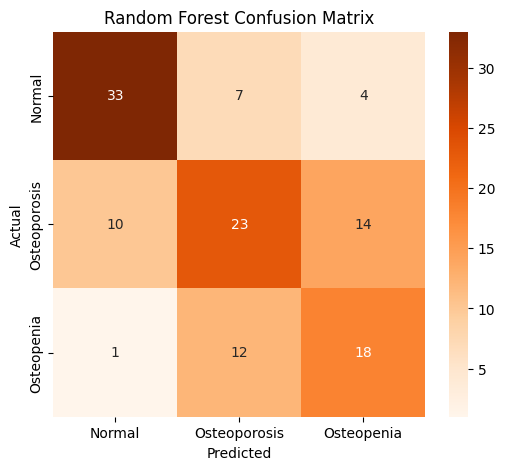

In [ ]:
# ============================================================
# 🔥 Confusion Matrix Heatmap
# ============================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Normal", "Osteoporosis", "Osteopenia"],
            yticklabels=["Normal", "Osteoporosis", "Osteopenia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


NameError: name 'feature_names' is not defined

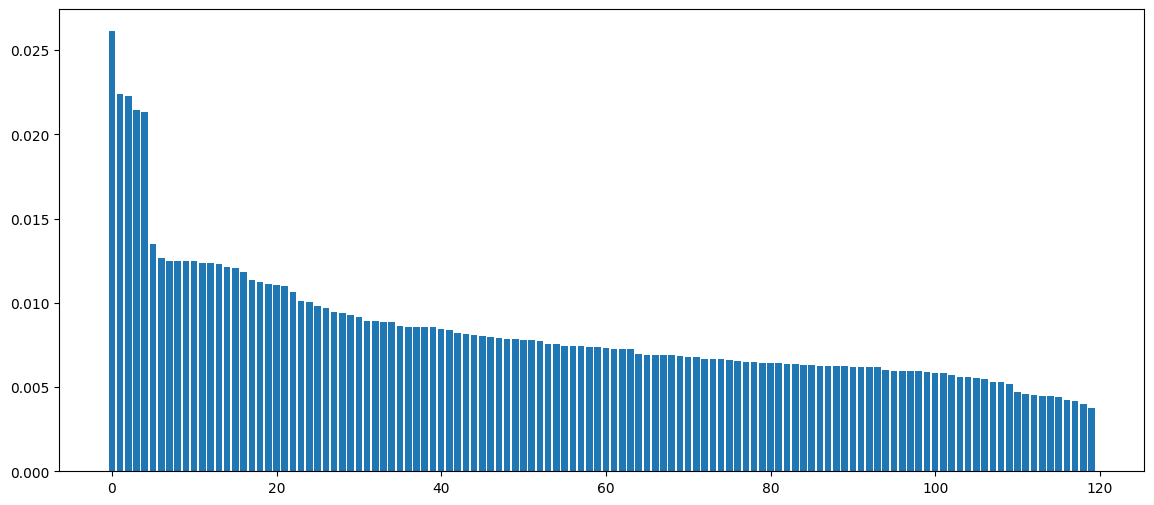

In [ ]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]   # sort descending

plt.figure(figsize=(14,6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

## 4. Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [ ]:
# ============================================================
# 🤖 Train Logistic Regression Classifier
# ============================================================
log_reg = LogisticRegression(
    solver="lbfgs",        # good default solver
    max_iter=1000,         # increase iterations to ensure convergence
    multi_class="auto",
    random_state=42
)
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Train Logistic Regression
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    multi_class="auto",
    random_state=42
)
log_reg.fit(X_train, y_train_int)  # use integer labels

# Predictions
y_pred = log_reg.predict(X_test)

# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_int, y_pred)
print("✅ Logistic Regression Accuracy:", round(acc * 100, 2), "%")


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# If y_test is one-hot encoded:
y_test_int = np.argmax(y_test, axis=1)

# Now classification report
print("\nClassification Report:\n")
print(classification_report(
    y_test_int, y_pred,
    target_names=["Normal", "Osteopenia", "Osteoporosis"]
))

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)
print("\nConfusion Matrix:\n", cm)


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert one-hot y_test to integer labels
y_test_int = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_int, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Normal", "Osteopenia", "Osteoporosis"],
            yticklabels=["Normal", "Osteopenia", "Osteoporosis"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

## 5. Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns

In [ ]:
# ============================================================
# 🌳 Train Decision Tree Classifier
# ============================================================
dt_clf = DecisionTreeClassifier(
    criterion="gini",   # or "entropy"
    max_depth=None,     # can set limit to avoid overfitting
    random_state=42
)
dt_clf.fit(X_train, y_train)

# Predictions
y_pred = dt_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("✅ Decision Tree Accuracy:", round(acc * 100, 2), "%")


✅ Decision Tree Accuracy: 51.64 %


In [ ]:
# ============================================================
# 📊 Classification Report
# ============================================================
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Osteoporosis", "Osteopenia"]))



Classification Report:

              precision    recall  f1-score   support

      Normal       0.64      0.80      0.71        44
Osteoporosis       0.49      0.47      0.48        47
  Osteopenia       0.27      0.19      0.23        31

    accuracy                           0.52       122
   macro avg       0.47      0.49      0.47       122
weighted avg       0.49      0.52      0.50       122



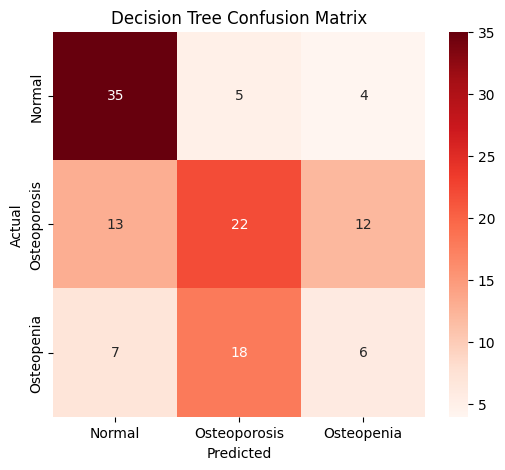

In [ ]:
# ============================================================
# 🔥 Confusion Matrix Heatmap
# ============================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Normal", "Osteoporosis", "Osteopenia"],
            yticklabels=["Normal", "Osteoporosis", "Osteopenia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()


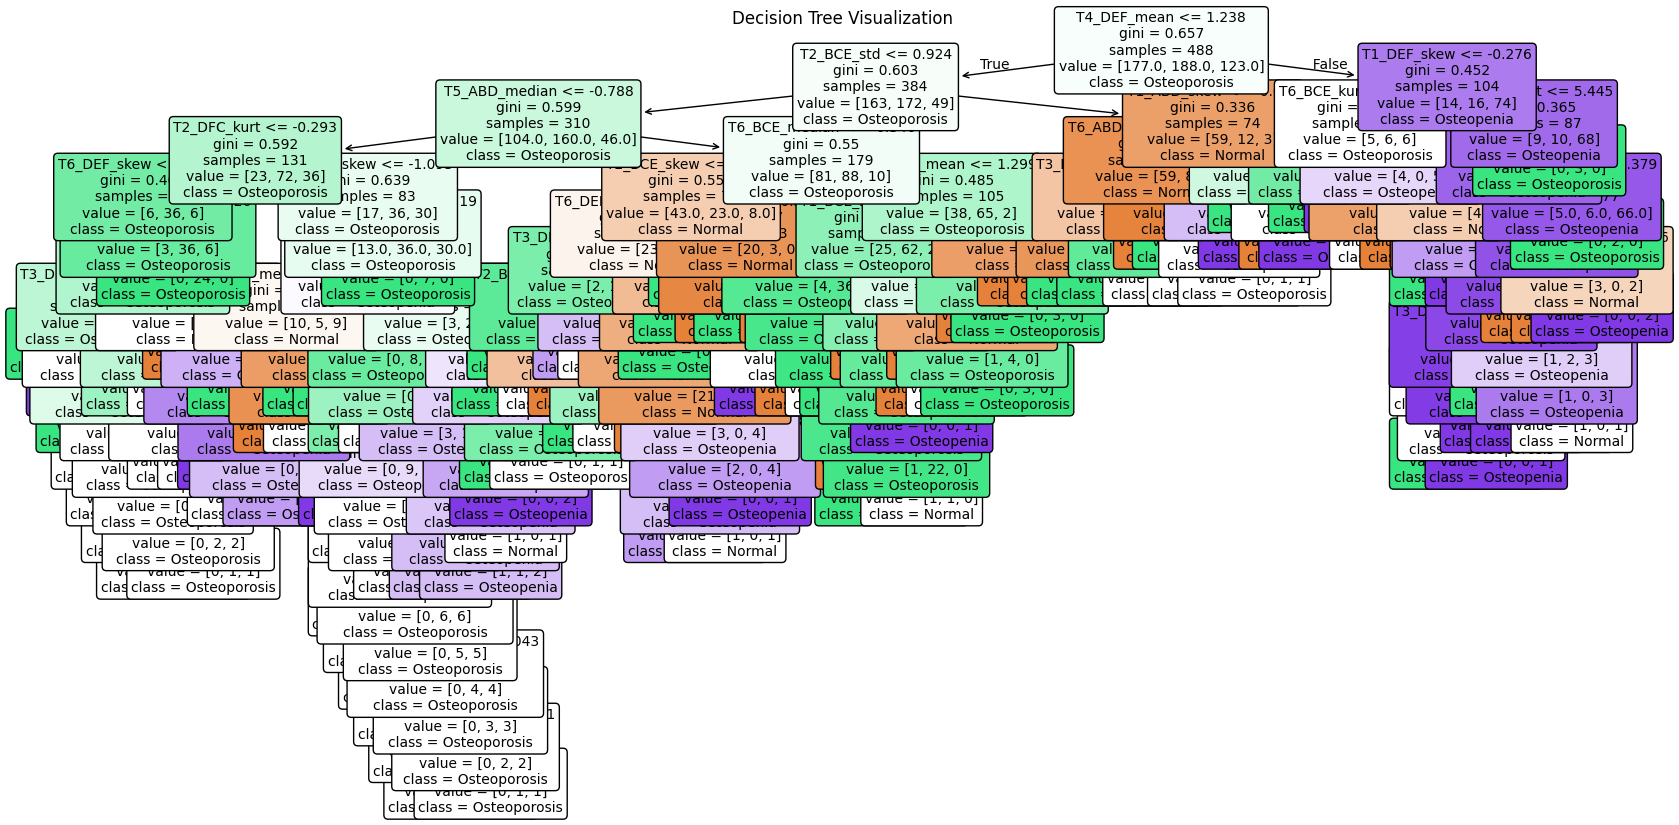

In [ ]:
# ============================================================
# 🌟 Visualize the Decision Tree
# ============================================================
plt.figure(figsize=(20,10))
plot_tree(dt_clf, filled=True,
          feature_names=df.drop(columns=["label"]).columns,
          class_names=["Normal", "Osteoporosis", "Osteopenia"],
          rounded=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


## 6. Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# ============================================================
# 🌲 Train Gradient Boosting Classifier
# ============================================================
gb_clf = GradientBoostingClassifier(
    n_estimators=200,   # number of boosting stages (trees)
    learning_rate=0.1,  # step size shrinkage
    max_depth=3,        # depth of individual trees
    random_state=42
)
gb_clf.fit(X_train, y_train)

# Predictions
y_pred = gb_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("✅ Gradient Boosting Accuracy:", round(acc * 100, 2), "%")


✅ Gradient Boosting Accuracy: 62.3 %


In [ ]:
# ============================================================
# 📊 Classification Report
# ============================================================
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Osteoporosis", "Osteopenia"]))



Classification Report:

              precision    recall  f1-score   support

      Normal       0.76      0.80      0.78        44
Osteoporosis       0.57      0.51      0.54        47
  Osteopenia       0.50      0.55      0.52        31

    accuracy                           0.62       122
   macro avg       0.61      0.62      0.61       122
weighted avg       0.62      0.62      0.62       122



In [ ]:
print("Training Accuracy:", accuracy_score(y_train, gb.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


NameError: name 'gb' is not defined

In [ ]:
# ============================================================
# 🔥 Confusion Matrix Heatmap
# ============================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma",
            xticklabels=["Normal", "Osteoporosis", "Osteopenia"],
            yticklabels=["Normal", "Osteoporosis", "Osteopenia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


In [ ]:
# ============================================================
# 🌟 Feature Importance Plot
# ============================================================
importances = gb_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df.drop(columns=["label"]).columns

plt.figure(figsize=(14,6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Gradient Boosting Feature Importances")
plt.tight_layout()
plt.show()


# Deep Learning

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
# ============================================================
# 📂 Dataset Path (must have subfolders: Normal, Osteoporosis, Osteopenia)
# ============================================================
dataset_path = "/content/drive/MyDrive/Original_inputs"

img_size = (224, 224)  # VGG16 expects 224x224
batch_size = 32


In [ ]:
# ============================================================
# 🖼️ Data Generators (Train/Test Split with Augmentation)
# ============================================================
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)


In [ ]:
# ============================================================
# 🔥 Build VGG16 Model (Transfer Learning)
# ============================================================
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")   # 3 classes: Normal, Osteoporosis, Osteopenia
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


In [ ]:
# ============================================================
# 🏋️ Train the Model
# ============================================================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


In [ ]:
# ============================================================
# 📊 Plot Training History
# ============================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


# FNN ALgorithm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# ================================
# 1. Load Dataset
# ================================
data = pd.read_csv("/content/drive/MyDrive/NITJSR_ML/dataset_features_golden (1).csv")   # replace with your file path

# Check dataset
print("Shape of data:", data.shape)
print("Columns:", data.columns)
print("Unique labels:", np.unique(data["label"]))

# ================================
# 2. Clean & Preprocess Data
# ================================
# Fill missing values (if any)
data = data.fillna(0)

# Features and Labels
X = data.drop("label", axis=1).values   # features
y = data["label"].values                # labels (0,1,2)

# Ensure labels are integers 0,1,2
y = y.astype(int)

# One-hot encode labels
y = to_categorical(y, num_classes=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ================================
# 3. Build Feedforward Neural Network
# ================================
model = Sequential([
    Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(16, activation="relu"),
    Dense(3, activation="softmax")  # 3 outputs for 3 classes
])

# Compile model (lower learning rate to avoid NaN issues)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# ================================
# 4. Train Model
# ================================
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# ================================
# 5. Evaluate Model
# ================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# ================================
# 6. Predict New Samples
# ================================
predictions = model.predict(X_test[:5])
print("\nRaw prediction probabilities:\n", predictions)
print("Predicted classes:", np.argmax(predictions, axis=1))
print("Actual classes   :", np.argmax(y_test[:5], axis=1))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# ================================
# Confusion Matrix & Classification Report
# ================================
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Osteopenia","Osteoporosis"],
            yticklabels=["Normal","Osteopenia","Osteoporosis"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=["Normal","Osteopenia","Osteoporosis"]
))

# ================================
# ROC Curve (One-vs-Rest for Multi-Class)
# ================================
plt.figure(figsize=(7,6))
for i, class_name in enumerate(["Normal","Osteopenia","Osteoporosis"]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

# ================================
# Loss & Accuracy Curves
# ================================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


# **1D CNN**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# ================================
# 1. Load & Clean Data
# ================================
data = pd.read_csv("/content/drive/MyDrive/NITJSR_ML/dataset_features_golden (1).csv")  # replace with your CSV file
data = data.fillna(0)                         # handle missing values

X = data.drop("label", axis=1).values
y = data["label"].astype(int).values

# Check for NaN or Inf
print("NaN values:", np.isnan(X).sum())
print("Inf values:", np.isinf(X).sum())
print("Unique labels:", np.unique(y))  # should be [0,1,2]

# ================================
# 2. Preprocess
# ================================
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
y = to_categorical(y, num_classes=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Reshape for 1D CNN: (samples, timesteps/features, channels=1)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# ================================
# 3. Build 1D CNN Model
# ================================
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.4),
    Dense(3, activation="softmax")  # 3 classes
])

# Compile with low learning rate to prevent NaN
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ================================
# 4. Train Model
# ================================
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

# ================================
# 5. Evaluate
# ================================
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Training Accuracy: {train_acc:.4f}, Training Loss: {train_loss:.4f}")
print(f"✅ Testing Accuracy: {test_acc:.4f}, Testing Loss: {test_loss:.4f}")

# ================================
# 6. Confusion Matrix & Classification Report
# ================================
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Osteopenia","Osteoporosis"],
            yticklabels=["Normal","Osteopenia","Osteoporosis"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=["Normal","Osteopenia","Osteoporosis"]
))

# ================================
# 7. ROC Curve (One-vs-Rest)
# ================================
plt.figure(figsize=(7,6))
for i, class_name in enumerate(["Normal","Osteopenia","Osteoporosis"]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

# ================================
# 8. Training & Validation Curves
# ================================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()
